
# Low-Rank completion via SVD
In this tutorial we will present an example of low-rank matrix completion.
Contrarily to most of the examples in this library (and PyLops), the regularizer
is here applied to a matrix, which is obtained by reshaping the model vector
that we wish to solve for.

In this example we will consider the following forward problem:

\begin{align}\mathbf{y} = \mathbf{R} \mathbf{x}\end{align}

where $\mathbf{R}$ is a restriction operator, which applied to
$\mathbf{x}=\operatorname{vec}(\mathbf{X})$, the vectorized version of a 2d image of
size $n \times m$, selects a reasonably small number of samples
$p \ll nm$ that form the vector $\mathbf{y}$. Note that any other
modelling operator could be used here, for example a 2D convolutional operator
in the case of deblurring or a 2D FFT plus restriction in the case of
MRI scanning.

The problem we want to solve can be mathematically described as:

\begin{align}\argmin_\mathbf{x} \frac{1}{2}\|\mathbf{y}-\mathbf{Rx}\|_2^2 + \mu \|\mathbf{X}\|_*\end{align}

or

\begin{align}\argmin_\mathbf{x} \frac{1}{2}\|\mathbf{y}-\mathbf{Rx}\|_2^2 \; \text{s.t.}
    \; \|\mathbf{X}\|_* < \mu\end{align}

where $\|\mathbf{X}\|_*=\sum_i \sigma_i$ is the nuclear norm of
$\mathbf{X}$ (i.e., the sum of the singular values).


In [1]:
# sphinx_gallery_thumbnail_number = 2
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyber-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
import pylops
import pyproximal

from scipy import misc

np.random.seed(0)
plt.close('all')

Let's start by loading a sample image



In [2]:
# Load image
X = misc.ascent()
X = X/np.max(X)
ny, nx = X.shape

/tmp/ipykernel_1007083/354645467.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


In [7]:
X.shape

(512, 512)

We can now define a :class:`pylops.Restriction` operator and look at how
the singular values of our image change when we remove some of its sample.



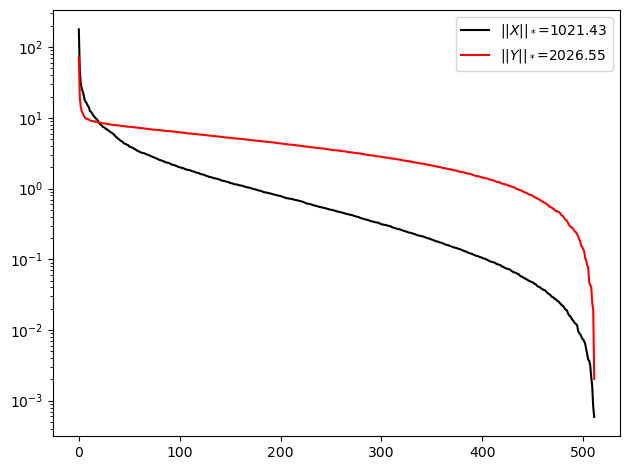

In [3]:
# Restriction operator
sub = 0.4
nsub = int(ny*nx*sub)
iava = np.random.permutation(np.arange(ny*nx))[:nsub]

Rop = pylops.Restriction(ny*nx, iava)
 
# Data
y = Rop * X.ravel()

# Masked data
Y = (Rop.H * Rop * X.ravel()).reshape(ny, nx)

# SVD of true and masked data
Ux, Sx, Vhx = np.linalg.svd(X, full_matrices=False)
Uy, Sy, Vhy = np.linalg.svd(Y, full_matrices=False)

plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.legend()
plt.tight_layout()

We observe that removing some samples from the image has led to an overall
increase in the singular values of $\mathbf{X}$, especially
those that are originally very small. As a consequence the nuclear norm of
$\mathbf{Y}$ (the masked image) is larger than that of
$\mathbf{X}$.

Let's now set up the inverse problem using the Proximal gradient algorithm



In [4]:
mu = .8
f = pyproximal.L2(Rop, y)
g = pyproximal.Nuclear((ny, nx), mu)

Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                      tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   2.80234e-01   9.762e+01   1.314e+03   1.412e+03   1.000e+00
     2   2.79868e-01   9.629e+01   1.223e+03   1.319e+03   1.000e+00
     3   2.89674e-01   9.359e+01   1.129e+03   1.222e+03   1.000e+00
     4   2.94030e-01   9.019e+01   1.035e+03   1.125e+03   1.000e+00
     5   3.00071e-01   8.645e+01   9.438e+02   1.030e+03   1.000e+00
     6   3.07346e-01   8.300e+01   8.565e+02   9.395e+02   1.000e+00
     7   3.16868e-01   8.025e+01   7.742e+02   8.545e+02   1.000e+00
     8   3.16858e-01   7.828e+01   6.988e+02   7.770e+02   1.000e+00
     9   3.13267e-01   7.674e+01   6.331e+02   7.098e+02   1.000e+00


Let's do the same with the constrained version



In [5]:
mu1 = 0.8 * np.sum(Sx)
g = pyproximal.proximal.NuclearBall((ny, nx), mu1)

Xpgc = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                       tau=1., niter=100, show=True)
Xpgc = Xpgc.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upgc, Spgc, Vhpgc = np.linalg.svd(Xpgc, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.NuclearBall'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   1.90702e-01   1.162e+03   0.000e+00   1.162e+03   1.000e+00
     2   2.53265e-01   6.432e+02   0.000e+00   6.432e+02   1.000e+00
     3   2.86505e-01   3.437e+02   1.000e+00   3.447e+02   1.000e+00
     4   3.04911e-01   1.802e+02   0.000e+00   1.802e+02   1.000e+00
     5   3.12726e-01   9.470e+01   1.000e+00   9.570e+01   1.000e+00
     6   3.15842e-01   5.078e+01   1.000e+00   5.178e+01   1.000e+00
     7   3.17937e-01   2.813e+01   0.000e+00   2.813e+01   1.000e+00
     8   3.18902e-01   1.623e+01   1.000e+00   1.723e+01   1.000e+00
     9   3.18828e-01   9.769e+00   0.000e+00   9.769e+00   1.000e

And finally we display the reconstructed image



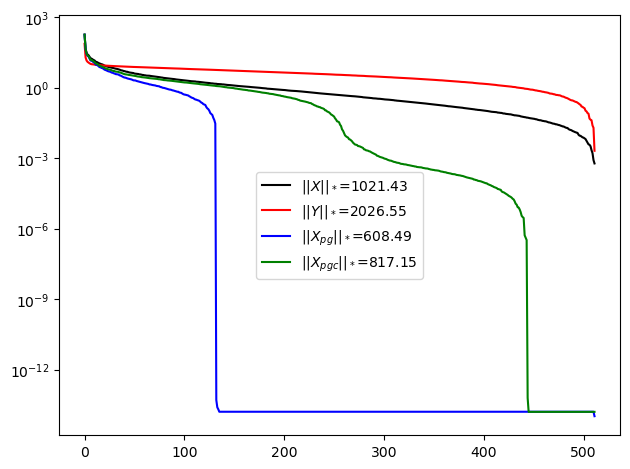

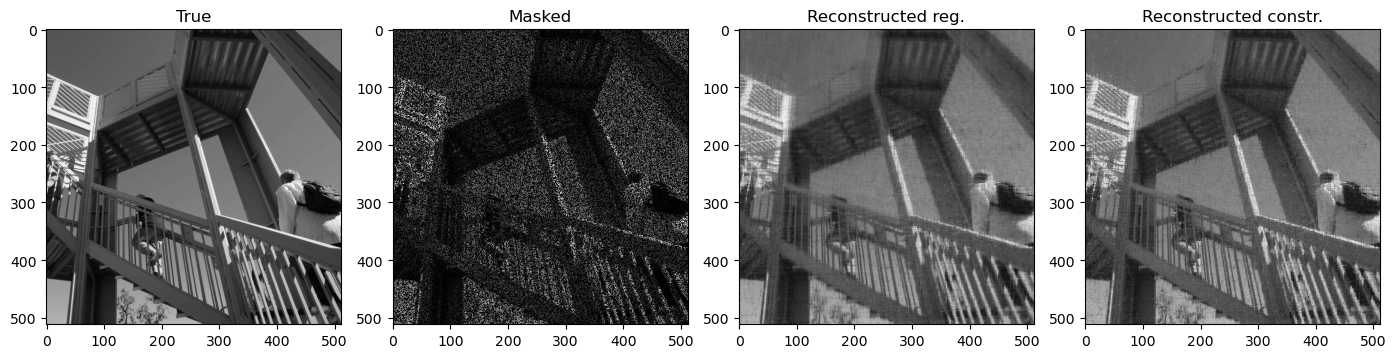

In [6]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.semilogy(Spg, 'b', label=r'$||X_{pg}||_*$=%.2f' % np.sum(Spg))
plt.semilogy(Spgc, 'g', label=r'$||X_{pgc}||_*$=%.2f' % np.sum(Spgc))
plt.legend()
plt.tight_layout()

fig, axs = plt.subplots(1, 4, figsize=(14, 6))
axs[0].imshow(X, cmap='gray')
axs[0].set_title('True')
axs[1].imshow(Y, cmap='gray')
axs[1].set_title('Masked')
axs[2].imshow(Xpg, cmap='gray')
axs[2].set_title('Reconstructed reg.')
axs[3].imshow(Xpgc, cmap='gray')
axs[3].set_title('Reconstructed constr.')
fig.tight_layout()